In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
import jieba
from nltk import FreqDist
from wordcloud import WordCloud
import re
from collections import defaultdict, Counter
import copy
from PIL import Image

In [2]:
# 以下代码从全局设置字体为Arial Unicode MS，解决显示中文问题
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# 解决中文字体下坐标轴负数的负号显示问题
plt.rcParams['axes.unicode_minus'] = False 

# Q2

In [3]:
catalog = pd.read_csv('data/catalogs.csv')

In [4]:
catalog.head()

,name,first,second,third
0,双汇 猪舌 700g/袋,生鲜,猪牛羊肉,猪肉
1,（满38减10）黑猪腊肉 湘西腊肉 即食小吃食猪肉干肉脯湖南张家界土家 香辣味,生鲜,猪牛羊肉,猪肉
2,精气神 猪肋排段（排骨） 400g/袋 山黑猪 黑猪肉 林间散养,生鲜,猪牛羊肉,猪肉
3,双汇 猪五花肉片 300g/袋 整肉原切 火锅食材,生鲜,猪牛羊肉,猪肉
4,农家散养新鲜现杀黑土猪肉 纯瘦肉 500g,生鲜,猪牛羊肉,猪肉


In [5]:
catalog['first'].unique()

array(['生鲜', '食品饮料、保健食品'], dtype=object)

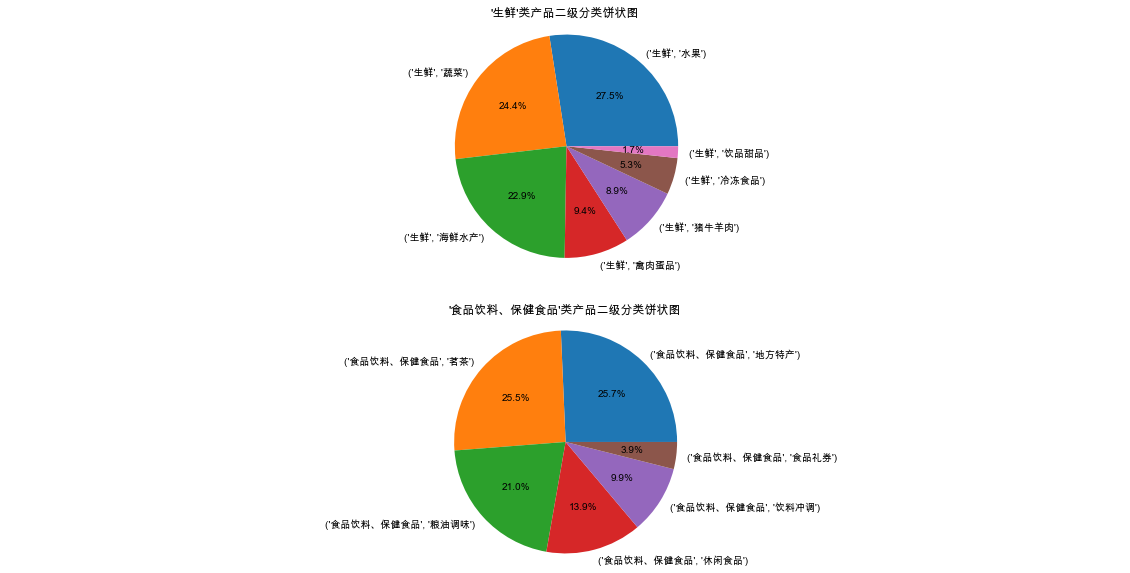

In [7]:
# 计算每个一级分类下二级分类的分布情况
grouped = catalog.groupby('first')['second'].value_counts()

# 绘制饼状图
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))  # 创建两个子图

for i, (first, group) in enumerate(grouped.groupby('first')):
    ax = axes[i]  # 选择第i个子图
    ax.pie(group, labels=group.index, autopct='%1.1f%%')
    ax.set_title(f'\'{first}\'类产品二级分类饼状图')
    ax.axis('equal')

plt.show()

对生鲜类产品二级分类饼图的分析如下：
* 水果类是占比最大的类别，其所占比例为27.5%，蔬菜类是占比第二大的类别，其所占比例为24.4%，海鲜水产位于第三名
* 禽肉蛋品、猪牛羊肉和冷冻食品占比相对较少，饮品甜品占比最少，只有1.7%
* 水果类、蔬菜类和海鲜水产占比相对较大，可能是因为这些类别的产品在人们的日常饮食中占据着重要的地位，而且市场需求量较大；禽肉蛋品、猪牛羊肉和冷冻食品占比较小，可能是因为这些类别的产品价格相对较高，导致购买量较少；饮品甜品占比最小，可能是因为这些类别的产品属于非必需品，市场需求相对较小

对食品饮料、保健食品产品二级分类饼图的分析如下：
* 地方特产、茗茶、粮油调味这三类产品占比位于前三，都超过了20%，其中地方特产和茗茶都超过了25%
* 休闲食品和饮料冲调占比相对较少，食品礼券占比最少，只有3.9%
* 地方特产和茗茶占比较高，可能是人们倾向于采购这类食品进行送礼，也可能与饮食文化有关；粮油调味占比较高，可能是因为这是必需品；食品礼券占比最少，可能是人们不倾向于这种送礼方式、也不习惯采购食品券然后兑换食品的生活方式

In [15]:
# 加载自己的词典
jieba.load_userdict('data/userdict.dat')

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/fw/rtq80_993_z57g2hhl8qb6s80000gn/T/jieba.cache
Loading model cost 0.579 seconds.
Prefix dict has been built successfully.


In [16]:
# 定义一个函数用于分词
def cut_words(text):
    words = jieba.cut(text, cut_all=False)
    res = []
    for word in words:
        if word == ' ':  # 把空格去掉
            continue
        else:
            res.append(word)
    return res

# 对 name 字段进行分词
catalog['name'] = catalog['name'].astype(str)
catalog['cut_name'] = catalog['name'].apply(cut_words)

In [17]:
# 统计每个商品分词后包含的词数
catalog['name_len'] = catalog['cut_name'].apply(lambda x: len(x))

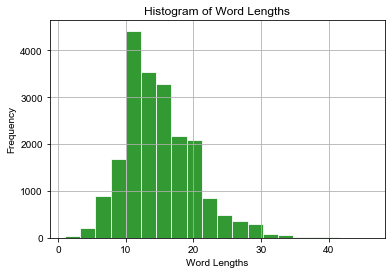

In [19]:
fresh_name = catalog[catalog['first'] == '生鲜']
# 绘制直方图
plt.hist(fresh_name['name_len'], bins=20, color='green', alpha=0.8, edgecolor='white')

# 添加标题和轴标签
plt.grid()
plt.title('Histogram of Word Lengths')
plt.xlabel('Word Lengths')
plt.ylabel('Frequency')

# 显示图形
plt.show()

现在绘制出了生鲜类商品分词后的直方图，开始绘制词云图

In [20]:
all_words = []
for cur in fresh_name['cut_name']:
    all_words.extend(cur)

In [21]:
fdisk = FreqDist(all_words)
most_common_words = fdisk.most_common(100)

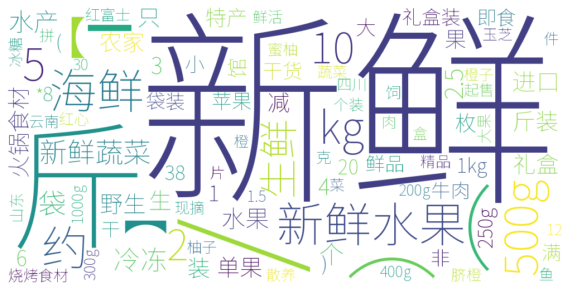

In [191]:
# 构建词云图
wc = WordCloud(background_color="white", font_path='SourceHanSansSC-VF.ttf', width=1000, height=500)
wc.generate_from_frequencies(dict(most_common_words))

# 显示词云图
plt.figure(figsize=(10, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

在上述步骤中，已经对一级品类为“食品饮料、保健食品”的数据分词结果进行了建模前的预处理，每个商品分词后的长度放在了'name_len'字段中

In [223]:
with open('cn_stopwords.txt', 'r', encoding='utf8') as f:
    stopwords = [word.strip() for word in f.read()]

# 去掉数字字母组合 去除特殊符号 去除停用词汇
def clean_text(text_list):
    res = []
    for text in text_list:
        tmp = re.sub(r"[{}]+".format('.,;《》？！“”‘’@#￥%…&×（）——+【】{};；●，。&～、|\s:：' + '*'), "", text)
        if re.match('^([a-z]|[A-Z])+$', tmp) or re.match('^[0-9]+(\\.)?[0-9]*(-)?[0-9]*(\\.)?[0-9]*$', tmp):
            continue
        if tmp != '' and tmp not in stopwords:
            res.append(tmp)
    return res

# 过滤掉不符合要求的词汇
# 这个写法比较丑，后续可以用面向对象封装一下pruned_words变量
def filter_pruned_words(text_list):
    res = []
    for text in text_list:
        if text in pruned_words:
            res.append(text)
    return res

In [229]:
def naive_bayes_func(catalog, min_count, max_count_rate, num_dim, first_name='食品饮料、保健食品'):
    df = copy.deepcopy(catalog[catalog['first'] == first_name])
    df['cut_name'] = df['cut_name'].apply(clean_text)
    df['name_len'] = df['cut_name'].apply(lambda x: len(x))
    
    # 使用Counter对词数进行计数
    word_count = Counter([token for cur_cut_name in food_and_drink['cut_name'] for token in cur_cut_name])

    # 计算总的商品数量
    total_items = len(df)
    max_count = max_count_rate * total_items

    # 筛选掉低频词和高频词
    pruned_words = [word for word in word_count if word_count[word] >= min_count 
                    and word_count[word] <= max_count]
    
    df['cut_name'] = df['cut_name'].apply(filter_pruned_words)
    
    # 使用Counter对词数进行计数
    word_count = Counter([token for cur_cut_name in df['cut_name'] for token in cur_cut_name])

    most_common = sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:num_dim]
    vocab = [pair[0] for pair in most_common]
    
    df['cut_name'] = df['cut_name'].apply(lambda x: ' '.join(x))
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(df['cut_name'], df['second'], test_size=0.2, random_state=1000)

    # 构建CountVectorizer对象
    vectorizer = CountVectorizer(vocabulary=vocab)
    dtm_train = vectorizer.fit_transform(X_train)
    dtm_test = vectorizer.fit_transform(X_test)
    
    # 创建朴素贝叶斯分类器
    nb = MultinomialNB()

    # 训练模型
    nb.fit(dtm_train, y_train)

    # 预测分类结果
    y_pred = nb.predict(dtm_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'acc:{acc}')
    
    return y_train, y_test, y_pred
    

In [225]:
y_train, y_test, y_pred = naive_bayes_func(catalog, 10, 0.75, 1000, first_name='食品饮料、保健食品')

acc:0.8465386971615275


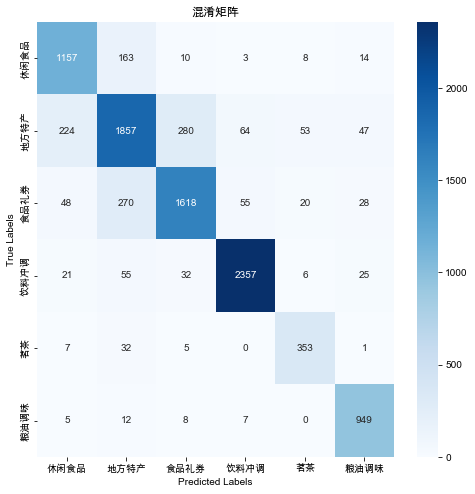

In [226]:
cur_confusion_matrix = confusion_matrix(y_test, y_pred)

labels = set(food_and_drink['second'])

# 绘制热力图
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cur_confusion_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=labels, yticklabels=labels, ax=ax) 
# 设置x轴标签
ax.set_xlabel("Predicted Labels")
# 设置y轴标签
ax.set_ylabel("True Labels")
# 设置标题
ax.set_title("混淆矩阵")
plt.show()

In [227]:
# 计算评估指标
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Macro Recall:", recall)
print("Macro Precision:", precision)
print("Macro F1 score:", f1)

Accuracy: 0.8465386971615275
Macro Recall: 0.8635786861192777
Macro Precision: 0.8399104678853445
Macro F1 score: 0.8507780083878435


* 模型准确率尚可，为84.6%，Macro Recall、Macro Precision和Macro F1 score也都比较高
* 从混淆矩阵来看，模型在对休闲食品、地方特产、食品礼券进行分类的时候容易出错，可能它们的特征比较接近，比如top1000词汇中的“200g”这个词汇，既可能在休闲食品中出现，比如“奶油味夏威夷果200g/袋”，也可能在地方特产中出现，比如“云南澄江特产速溶藕粉代餐冲调粉类美食 200g*3盒”
* 模型对饮料冲调、粮油调味的分类效果较好，同时饮料冲调和名茶基本没有混淆，说明特征上比较不同，可能“茶”之类的词在饮料冲调这类中很少出现

接下来改变参数，首先改变阈值

In [231]:
# 设置低频词、高频词阈值为50和0.7
y_train, y_test, y_pred = naive_bayes_func(catalog, 50, 0.7, 1000, first_name='食品饮料、保健食品')

acc:0.8465386971615275


发现调整阈值后，正确率没有发生变化，可能是真正决定模型分类结果的特征是那些词频次数不太高也不太低的，所以适当改变阈值没有影响结果

接下来改变矩阵维度进行尝试

In [230]:
# 设置矩阵维度为900
y_train, y_test, y_pred = naive_bayes_func(catalog, 10, 0.75, 900, first_name='食品饮料、保健食品')

acc:0.842862977333061


In [232]:
# 设置矩阵维度为1100
y_train, y_test, y_pred = naive_bayes_func(catalog, 10, 0.75, 1100, first_name='食品饮料、保健食品')

acc:0.8487849703900348


减小矩阵维度后性能降低，增加矩阵维度后性能增大，说明更多的特征确实能带来更好的性能，但也要注意过拟合风险，最好再引入一个验证集